In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as IPyDisplay
import time
import seaborn as sns; sns.set(); sns.set(style="whitegrid", color_codes=True)
import pandas as pd

# Read Data

In [2]:
import torch

from helpers.data_generator import generate_data, normalize


epochs = 300
batch_size = 100

def accuracy(predicted_logits, reference, argmax=True):
    """Compute the ratio of correctly predicted labels"""
    if argmax:
        labels = torch.argmax(predicted_logits, 1)
    else:
        labels = predicted_logits
    correct_predictions = labels.int().eq(reference.int())
    return correct_predictions.sum().float() / correct_predictions.nelement()

# autograd globally off
torch.set_grad_enabled(False)

train_data, train_label = generate_data()
test_data, test_label = generate_data()

mean, std = train_data.mean(), train_data.std()
print("Mean= ", mean, "STD= ",std)

train_data, test_data = normalize(train_data, test_data)
print("--- Dataset ---")
print("Train X: ", train_data.size(), " | Train y: ", train_label.size())
print(" Test X: ",  test_data.size(), " |  Test y: ", test_label.size())

Mean=  tensor(0.4973) STD=  tensor(0.2878)
--- Dataset ---
Train X:  torch.Size([1000, 2])  | Train y:  torch.Size([1000])
 Test X:  torch.Size([1000, 2])  |  Test y:  torch.Size([1000])


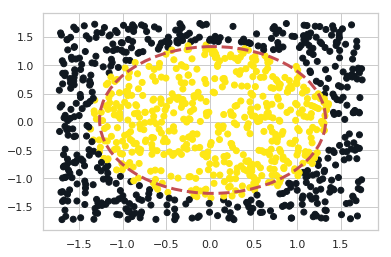

In [3]:
circle1 = plt.Circle(((0.5-mean.item())/np.power(std,2), (0.5-mean.item())/np.power(std,2)), ((1/np.sqrt(2*np.pi))-mean)/np.power(std,2.07), color='r', fill=False, lw=3, ls="--")

fig, ax = plt.subplots()
ax.scatter(train_data[:,0].numpy(), train_data[:,1].numpy(), c=["#101820FF" if x==0 else "#FEE715FF" for x in np.squeeze(train_label.numpy())])
ax.add_artist(circle1)

---

# Our DL Framework Performance

In [4]:
from Sequential import Sequential
from activations.ReLu import Relu
from activations.Tanh import Tanh
from activations.Mish import Mish
from layers.Linear import Linear
from losses.mse import MSE
from optimizers.SGD import SGD
from weight_initialization.xavier_uniform import xavier_uniform

In [5]:
def collect_data_minidl_framework(num_runs):
    data = []
    for run in range(num_runs):
        epochs, train_losses, test_losses, train_accuracies, test_accuracies, train_errors, test_errors = minidl_framework(verbose=0, plot=False)
        for e, trl, tel, tra, tea, tre, tee in zip(epochs, train_losses, test_losses, train_accuracies, test_accuracies, train_errors, test_errors):
            #data.append([run, e, trl, tel, tra, tea, tre, tee])
            data.append([run, e, "train", "loss", trl])
            data.append([run, e, "test", "loss", tel])
            data.append([run, e, "train", "accuracy", tra])
            data.append([run, e, "test", "accuracy", tea])
            data.append([run, e, "train", "error", tre])
            data.append([run, e, "test", "error", tee])
    df = pd.DataFrame(data, columns=[ 'run', 'epochs', 'dataset', 'measure', 'value'])
    df['framework'] = df.apply(lambda x: "MiniDL", axis=1)
    df.to_csv("data/dfs/minidl_framework.csv", index=False)
    return df

In [6]:
def minidl_framework(verbose=0, plot=False):

    layers =[]
    # input layer (2 input units)
    linear1 = Linear(2, 25, bias= True, weight_init=xavier_uniform)

    # 3 hidden layers (each 25 units)
    linear2 = Linear(25, 25, bias= True, weight_init=xavier_uniform)
    linear3 = Linear(25, 25, bias= True, weight_init=xavier_uniform)
    linear4 = Linear(25, 25, bias= True, weight_init=xavier_uniform)

    # output layer (2 output units)
    linear5 = Linear(25, 2, bias= True, weight_init=xavier_uniform)


    layers.append(linear1)
    layers.append(Relu())
    layers.append(linear2)
    layers.append(Relu())
    layers.append(linear3)
    layers.append(Relu())
    layers.append(linear4)
    layers.append(Tanh())
    layers.append(linear5)

    model = Sequential(layers)

    criterion = MSE()
    optimizer = SGD(model, lr = 0.1)


    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []
    train_errors, test_errors = [], []

    ret_val = ""
    verbose = 0 


    for epoch in range(1, epochs+1):
        ret_val += "Epoch: " + str(epoch) + "\n"

        # TRAINING
        _losses = []
        for batch_idx in range(0, train_data.size(0), batch_size):
            # axis 0, start from batch_idx until batch_idx+batch_size
            output = model.forward(train_data.narrow(0, batch_idx, batch_size))

            # Calculate loss
            loss = criterion.forward(output, train_label.narrow(0, batch_idx, batch_size))
            _losses.append(loss)
            ret_val += "Loss: "+str(loss)+"\n"

            # put to zero weights and bias
            optimizer.zero_grad()

            ## Backpropagation
            # Calculate grad of loss
            loss_grad = criterion.backward()

            # Grad of the model
            model.backward(loss_grad)

            # Update parameters
            optimizer.step()

        train_losses.append(np.mean(_losses))
        train_prediction = model.forward(train_data)
        acc = accuracy(train_prediction, train_label).item()
        train_accuracies.append(acc)
        train_errors.append(1-acc)
        ret_val += "Train Accuracy: {:.2e}".format(acc)

        # EVALUATION
        _losses = []
        for batch_idx in range(0, test_data.size(0), batch_size):
            # axis 0, start from batch_idx until batch_idx+batch_size
            output = model.forward(test_data.narrow(0, batch_idx, batch_size))

            # Calculate loss
            loss = criterion.forward(output, test_label.narrow(0, batch_idx, batch_size))
            _losses.append(loss)
            ret_val += "Test Loss: {:.2e}".format(loss.item())

        test_losses.append(np.mean(_losses))
        test_prediction = model.forward(test_data)
        acc = accuracy(test_prediction, test_label).item()
        test_accuracies.append(acc)    
        test_errors.append(1-acc)
        ret_val += "Test Accuracy: {:.2e}".format(acc)


        if plot:
            pred = torch.argmax(test_prediction, 1)  
            fig, ax = plt.subplots(figsize=(10,8))
            ax.scatter(test_data[:,0].numpy(), test_data[:,1].numpy(), c=["#101820FF" if x==0 else "#FEE715FF" for x in np.squeeze(pred.numpy())])
            circle1 = plt.Circle(((0.5-mean.item())/np.power(std,2), (0.5-mean.item())/np.power(std,2)), ((1/np.sqrt(2*np.pi))-mean)/np.power(std,2.07), color='r', fill=False, lw=3, ls="--")
            ax.add_artist(circle1)
            ax.set_title(f"Epoch {epoch}/{epochs}", fontdict={"fontsize":20, "fontweight":1}, pad=15);
            IPyDisplay.clear_output(wait=True)
            IPyDisplay.display(plt.gcf())
            plt.close();
            time.sleep(0.1)

    if verbose: print(ret_val)

    return range(1, epochs+1), train_losses, test_losses, train_accuracies, test_accuracies, train_errors, test_errors

In [7]:
df1 = collect_data_minidl_framework(num_runs=15)

In [8]:
df1.shape

(27000, 6)

In [9]:
df1.head()

,run,epochs,dataset,measure,value,framework
0,0,1,train,loss,0.702398,MiniDL
1,0,1,test,loss,0.508990,MiniDL
2,0,1,train,accuracy,0.489000,MiniDL
3,0,1,test,accuracy,0.525000,MiniDL
4,0,1,train,error,0.511000,MiniDL


# PyTorch Framework

In [10]:
from torch import nn

In [11]:
def collect_data_pytorch_framework(num_runs):
    data = []
    for run in range(num_runs):
        epochs, train_losses, test_losses, train_accuracies, test_accuracies, train_errors, test_errors = pytorch_framework(verbose=0, plot=False)
        for e, trl, tel, tra, tea, tre, tee in zip(epochs, train_losses, test_losses, train_accuracies, test_accuracies, train_errors, test_errors):
            #data.append([run, e, trl, tel, tra, tea, tre, tee])
            data.append([run, e, "train", "loss", trl])
            data.append([run, e, "test", "loss", tel])
            data.append([run, e, "train", "accuracy", tra])
            data.append([run, e, "test", "accuracy", tea])
            data.append([run, e, "train", "error", tre])
            data.append([run, e, "test", "error", tee])
    df = pd.DataFrame(data, columns=[ 'run', 'epochs', 'dataset', 'measure', 'value'])
    df['framework'] = df.apply(lambda x: "PyTorch", axis=1)
    df.to_csv("data/dfs/pytorch_framework.csv", index=False)
    return df

In [12]:
def pytorch_framework(verbose=0, plot=False):
    
    def _init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform(m.weight)
    
    # autograd globally off
    torch.set_grad_enabled(True)

    layers =[]
    # input layer (2 input units)
    linear1 = nn.Linear(2, 25, bias=True)

    # 3 hidden layers (each 25 units)
    linear2 = nn.Linear(25, 25, bias=True)
    linear3 = nn.Linear(25, 25, bias=True)
    linear4 = nn.Linear(25, 25, bias=True)

    # output layer (2 output units)
    linear5 = nn.Linear(25, 2, bias=True)

    layers.append(linear1)
    layers.append(nn.ReLU())
    layers.append(linear2)
    layers.append(nn.ReLU())
    layers.append(linear3)
    layers.append(nn.ReLU())
    layers.append(linear4)
    layers.append(nn.Tanh())
    layers.append(linear5)

    model = nn.Sequential(*layers)
    model.apply(_init_weights)

    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)


    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []
    train_errors, test_errors = [], []

    ret_val = ""
    verbose = 0 


    for epoch in range(1, epochs+1):
        ret_val += "Epoch: " + str(epoch) + "\n"

        # Enable training mode (automatic differentiation + batch norm)
        model.train()

        _losses = []
        # TRAINING
        for batch_idx in range(0, train_data.size(0), batch_size):
            # axis 0, start from batch_idx until batch_idx+batch_size
            batch_data = train_data.narrow(0, batch_idx, batch_size)

            # put to zero weights and bias
            optimizer.zero_grad()

            output = model(batch_data)

            # Calculate loss
            y = torch.eye(2) 
            loss = criterion(output, y[train_label.narrow(0, batch_idx, batch_size).long()])        
            _losses.append(loss.item())
            ret_val += "Loss: "+str(loss)+"\n"

            ## Backpropagation
            # Calculate grad of loss
            loss.backward()

            # Grad of the model
            #model.backward(loss_grad)

            # Update parameters
            optimizer.step()

        train_losses.append(np.median(_losses))
        train_prediction = model(train_data)
        acc = accuracy(train_prediction, train_label).item()
        train_accuracies.append(acc)
        train_errors.append(1-acc)
        ret_val += "Train Accuracy: {:.2e}".format(acc)

        # EVALUATION

        # Enable evaluation mode
        model.eval()

        _losses = []
        for batch_idx in range(0, test_data.size(0), batch_size):
            batch_data = test_data.narrow(0, batch_idx, batch_size)

            # axis 0, start from batch_idx until batch_idx+batch_size
            output = model(batch_data)

            # Calculate loss
            y = torch.eye(2) 
            loss = criterion(output, y[train_label.narrow(0, batch_idx, batch_size).long()])
            _losses.append(loss.item())
            ret_val += "Test Loss: {:.2e}".format(loss.item())

        test_losses.append(np.median(_losses))
        test_prediction = model(test_data)
        acc = accuracy(test_prediction, test_label).item()
        test_accuracies.append(acc)    
        test_errors.append(1-acc)
        ret_val += "Test Accuracy: {:.2e}".format(acc)


        if plot:
            pred = torch.argmax(test_prediction, 1)  
            fig, ax = plt.subplots(figsize=(10,8))
            ax.scatter(test_data[:,0].detach().numpy(), test_data[:,1].detach().numpy(), c=["#101820FF" if x==0 else "#FEE715FF" for x in np.squeeze(pred.detach().numpy())])
            circle1 = plt.Circle(((0.5-mean.item())/np.power(std,2), (0.5-mean.item())/np.power(std,2)), ((1/np.sqrt(2*np.pi))-mean)/np.power(std,2.07), color='r', fill=False, lw=3, ls="--")
            ax.add_artist(circle1)
            ax.set_title(f"Epoch {epoch}/{epochs}", fontdict={"fontsize":20, "fontweight":1}, pad=15);
            IPyDisplay.clear_output(wait=True)
            IPyDisplay.display(plt.gcf())
            plt.close();
            time.sleep(0.1)

    if verbose: print(ret_val)  
        
    return range(1, epochs+1), train_losses, test_losses, train_accuracies, test_accuracies, train_errors, test_errors

In [13]:
df2 = collect_data_pytorch_framework(num_runs=15)

/home/jelena/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  """


In [14]:
df2.head()

,run,epochs,dataset,measure,value,framework
0,0,1,train,loss,0.432859,PyTorch
1,0,1,test,loss,0.318393,PyTorch
2,0,1,train,accuracy,0.291000,PyTorch
3,0,1,test,accuracy,0.250000,PyTorch
4,0,1,train,error,0.709000,PyTorch


---

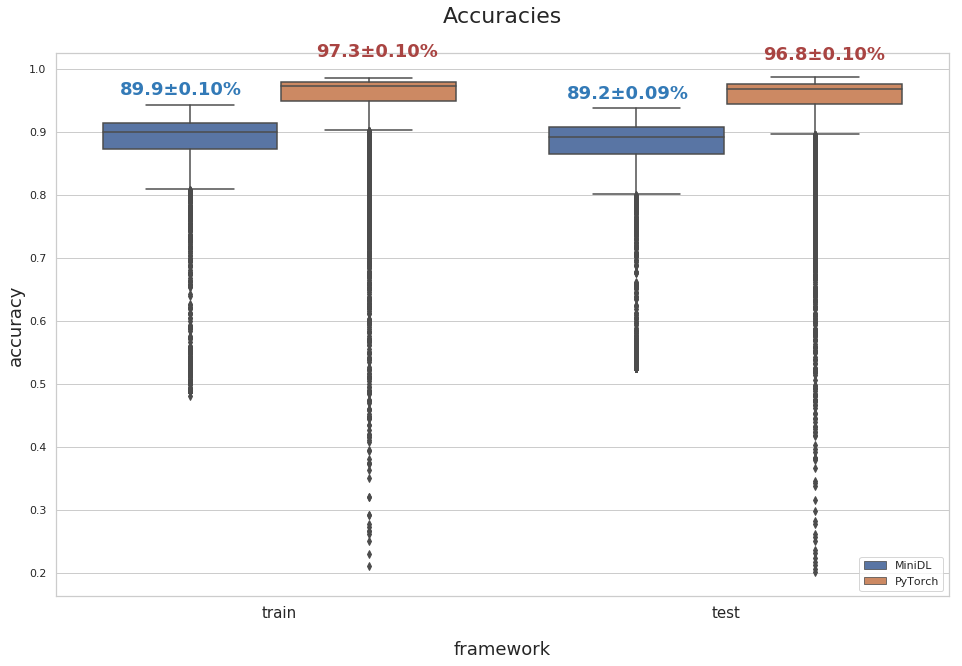

In [34]:
df = pd.concat([df1, df2])

mapping1 = {0: ("MiniDL", "train"), 1: ("MiniDL","test")}
mapping2 = {0: ('PyTorch', 'train'), 1:('PyTorch', 'test')}

fig, ax = plt.subplots(figsize=(16,10))

df = df[df.measure=="accuracy"]

box_plot = sns.boxplot(x="dataset", y="value", hue="framework", data=df, ax=ax)
box_plot.set_xticklabels(box_plot.get_xticklabels(), fontsize=15)#, rotation=45)
ax.set_xlabel("framework", fontsize=18, labelpad=20);
ax.set_ylabel("accuracy", fontsize=18);
ax.set_title("Accuracies", fontdict={"fontsize":22, "fontweight":1}, pad=30);
ax.legend(loc=4)

medians = df[df.framework=='MiniDL'].groupby(['framework', 'dataset'])['value'].median()#.sort_values(ascending=False)
stds = df[df.framework=='MiniDL'].groupby(['framework', 'dataset'])['value'].std()
vertical_offset = df[df.framework=='MiniDL']['value'].mean() * 0.07 # offset from median for display
horizontal_offset = 0.22
for xtick in box_plot.get_xticks():
    box_plot.text(xtick-horizontal_offset, 
                  medians[mapping1[xtick][0], mapping1[xtick][1]] + vertical_offset, 
                  f"{medians[mapping1[xtick][0], mapping1[xtick][1]]*100:.1f}±{stds[mapping1[xtick][0], mapping1[xtick][1]]:.2f}%", 
                  horizontalalignment='center', 
                  size='x-small', weight='semibold', fontsize=18, color="#337AB7")
    
medians = df[df.framework=='PyTorch'].groupby(['framework', 'dataset'])['value'].median()#.sort_values(ascending=False)

stds = df[df.framework=='PyTorch'].groupby(['framework', 'dataset'])['value'].std()
vertical_offset = df[df.framework=='PyTorch']['value'].mean() * 0.05 # offset from median for display
horizontal_offset = 0.22
for xtick in box_plot.get_xticks():
    box_plot.text(xtick+horizontal_offset, 
                  medians[mapping2[xtick][0], mapping2[xtick][1]] + vertical_offset, 
                  f"{medians[mapping2[xtick][0], mapping2[xtick][1]]*100:.1f}±{stds[mapping2[xtick][0], mapping2[xtick][1]]:.2f}%", 
                  horizontalalignment='center', 
                  size='x-small', weight='semibold', fontsize=18, color="#A94442")

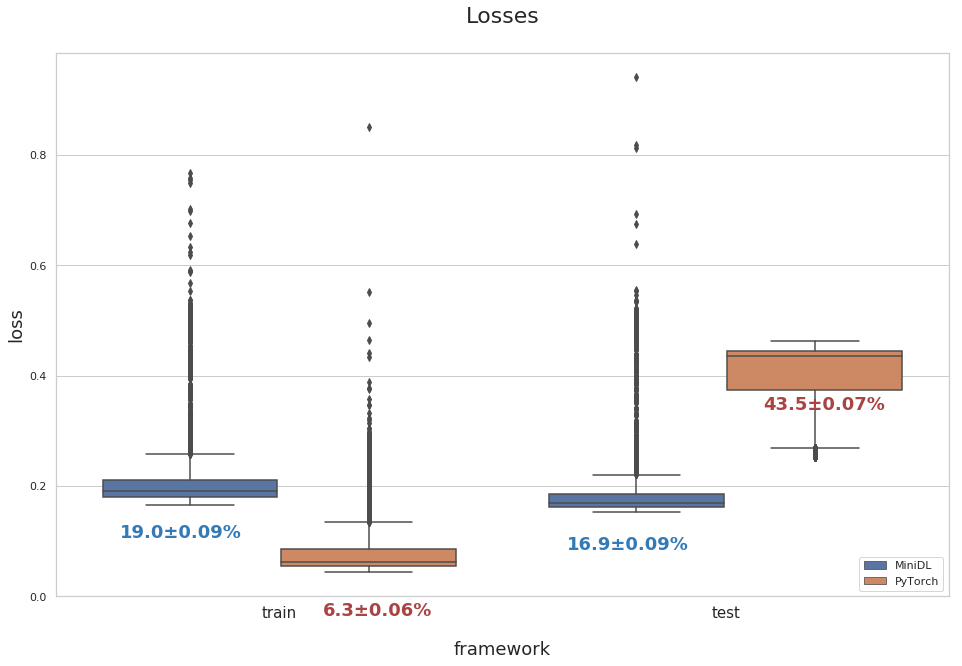

In [30]:
df = pd.concat([df1, df2])

mapping1 = {0: ("MiniDL", "train"), 1: ("MiniDL","test")}
mapping2 = {0: ('PyTorch', 'train'), 1:('PyTorch', 'test')}

fig, ax = plt.subplots(figsize=(16,10))

df = df[df.measure=="loss"]

box_plot = sns.boxplot(x="dataset", y="value", hue="framework", data=df, ax=ax)
box_plot.set_xticklabels(box_plot.get_xticklabels(), fontsize=15)#, rotation=45)
ax.set_xlabel("framework", fontsize=18, labelpad=20);
ax.set_ylabel("loss", fontsize=18);
ax.set_title("Losses", fontdict={"fontsize":22, "fontweight":1}, pad=30);
ax.legend(loc=4)

medians = df[df.framework=='MiniDL'].groupby(['framework', 'dataset'])['value'].median()#.sort_values(ascending=False)
stds = df[df.framework=='MiniDL'].groupby(['framework', 'dataset'])['value'].std()
vertical_offset = -df[df.framework=='MiniDL']['value'].mean() * 0.4 # offset from median for display
horizontal_offset = 0.22
for xtick in box_plot.get_xticks():
    box_plot.text(xtick-horizontal_offset, 
                  medians[mapping1[xtick][0], mapping1[xtick][1]] + vertical_offset, 
                  f"{medians[mapping1[xtick][0], mapping1[xtick][1]]*100:.1f}±{stds[mapping1[xtick][0], mapping1[xtick][1]]:.2f}%", 
                  horizontalalignment='center', 
                  size='x-small', weight='semibold', fontsize=18, color="#337AB7")
    
medians = df[df.framework=='PyTorch'].groupby(['framework', 'dataset'])['value'].median()#.sort_values(ascending=False)

stds = df[df.framework=='PyTorch'].groupby(['framework', 'dataset'])['value'].std()
vertical_offset = -df[df.framework=='PyTorch']['value'].mean() * 0.4 # offset from median for display
horizontal_offset = 0.22
for xtick in box_plot.get_xticks():
    box_plot.text(xtick+horizontal_offset, 
                  medians[mapping2[xtick][0], mapping2[xtick][1]] + vertical_offset, 
                  f"{medians[mapping2[xtick][0], mapping2[xtick][1]]*100:.1f}±{stds[mapping2[xtick][0], mapping2[xtick][1]]:.2f}%", 
                  horizontalalignment='center', 
                  size='x-small', weight='semibold', fontsize=18, color="#A94442")

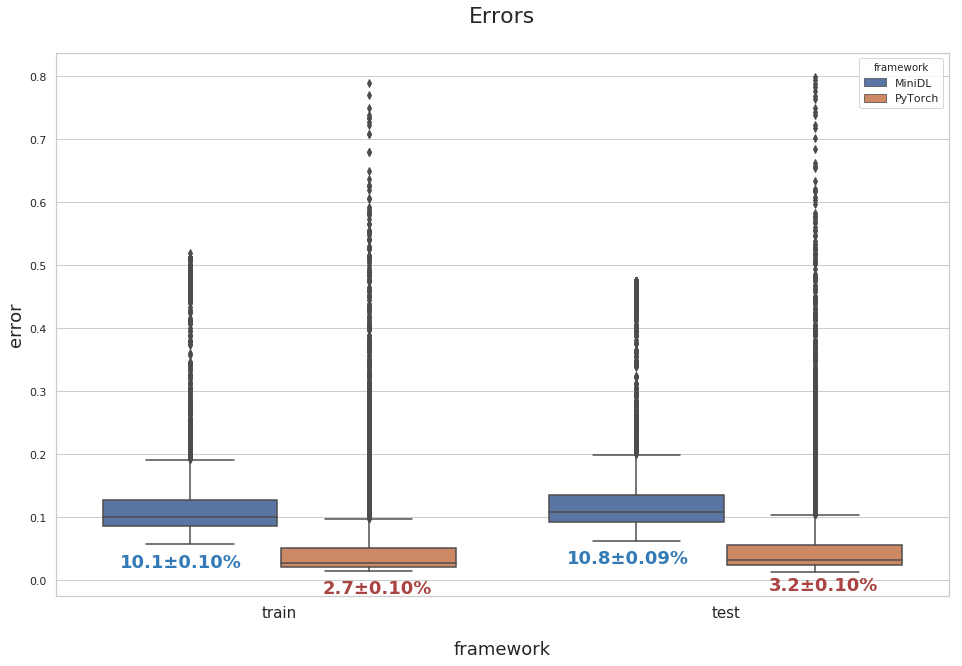

In [35]:
df = pd.concat([df1, df2])

mapping1 = {0: ("MiniDL", "train"), 1: ("MiniDL","test")}
mapping2 = {0: ('PyTorch', 'train'), 1:('PyTorch', 'test')}

fig, ax = plt.subplots(figsize=(16,10))

df = df[df.measure=="error"]

box_plot = sns.boxplot(x="dataset", y="value", hue="framework", data=df, ax=ax)
box_plot.set_xticklabels(box_plot.get_xticklabels(), fontsize=15)#, rotation=45)
ax.set_xlabel("framework", fontsize=18, labelpad=20);
ax.set_ylabel("error", fontsize=18);
ax.set_title("Errors", fontdict={"fontsize":22, "fontweight":1}, pad=30);


medians = df[df.framework=='MiniDL'].groupby(['framework', 'dataset'])['value'].median()#.sort_values(ascending=False)
stds = df[df.framework=='MiniDL'].groupby(['framework', 'dataset'])['value'].std()
vertical_offset = -df[df.framework=='MiniDL']['value'].mean() * 0.6 # offset from median for display
horizontal_offset = 0.22
for xtick in box_plot.get_xticks():
    box_plot.text(xtick-horizontal_offset, 
                  medians[mapping1[xtick][0], mapping1[xtick][1]] + vertical_offset, 
                  f"{medians[mapping1[xtick][0], mapping1[xtick][1]]*100:.1f}±{stds[mapping1[xtick][0], mapping1[xtick][1]]:.2f}%", 
                  horizontalalignment='center', 
                  size='x-small', weight='semibold', fontsize=18, color='#337AB7')
    
medians = df[df.framework=='PyTorch'].groupby(['framework', 'dataset'])['value'].median()#.sort_values(ascending=False)
stds = df[df.framework=='PyTorch'].groupby(['framework', 'dataset'])['value'].std()
vertical_offset = -df[df.framework=='PyTorch']['value'].mean() * 0.7 # offset from median for display
horizontal_offset = 0.22
for xtick in box_plot.get_xticks():
    box_plot.text(xtick+horizontal_offset, 
                  medians[mapping2[xtick][0], mapping2[xtick][1]] + vertical_offset, 
                  f"{medians[mapping2[xtick][0], mapping2[xtick][1]]*100:.1f}±{stds[mapping2[xtick][0], mapping2[xtick][1]]:.2f}%", 
                  horizontalalignment='center', 
                  size='x-small', weight='semibold', fontsize=18, color="#A94442")

---

# Mish

In [ ]:
verbose=0

In [ ]:
layers =[]
# input layer (2 input units)
linear1 = Linear(2, 25, bias= True, weight_init=xavier_uniform)

# 3 hidden layers (each 25 units)
linear2 = Linear(25, 25, bias= True, weight_init=xavier_uniform)
linear3 = Linear(25, 25, bias= True, weight_init=xavier_uniform)
linear4 = Linear(25, 25, bias= True, weight_init=xavier_uniform)

# output layer (2 output units)
linear5 = Linear(25, 2, bias= True, weight_init=xavier_uniform)


layers.append(linear1)
layers.append(Mish())
layers.append(linear2)
layers.append(Mish())
layers.append(linear3)
layers.append(Mish())
layers.append(linear4)
layers.append(Tanh())
layers.append(linear5)

model = Sequential(layers)

criterion = MSE()
optimizer = SGD(model, lr = 0.1)

losses2 = []
accuracies2 = []
errors2 = []
ret_val2 = ""

for epoch in range(1, epochs+1):
    ret_val2 += "Epoch: " + str(epoch) + "\n"
    for batch_idx in range(0, train_data.size(0), batch_size):
        # axis 0, start from batch_idx until batch_idx+batch_size
        output = model.forward(train_data.narrow(0, batch_idx, batch_size))

        # Calculate loss
        loss = criterion.forward(output, train_label.narrow(0, batch_idx, batch_size))
        losses2.append(loss)
        ret_val2 += "Loss: "+str(loss)+"\n"

        # put to zero weights and bias
        optimizer.zero_grad()

        ##Backpropagation
        # Calculate grad of loss
        loss_grad = criterion.backward()

        # Grad of the model
        model.backward(loss_grad)

        # Update parameters
        optimizer.step()
        
        
     

    test_prediction = model.forward(test_data)
    acc = accuracy(test_prediction, test_label)
    accuracies2.append(acc)
    
    errors2.append(1-acc)
    ret_val2 += "Accuracy: "+ str(acc)+"\n"
    
    pred = torch.argmax(test_prediction, 1)
    fig, ax = plt.subplots(figsize=(10,8))
    ax.scatter(test_data[:,0].numpy(), test_data[:,1].numpy(), c=["#101820FF" if x==0 else "#FEE715FF" for x in np.squeeze(pred.numpy())])
    circle1 = plt.Circle(((0.5-mean.item())/np.power(std,2), (0.5-mean.item())/np.power(std,2)), ((1/np.sqrt(2*np.pi))-mean)/np.power(std,2.07), color='r', fill=False, lw=3, ls="--")
    ax.add_artist(circle1)
    ax.set_title(f"Epoch {epoch}/{epochs}", fontdict={"fontsize":20, "fontweight":1}, pad=15);
    IPyDisplay.clear_output(wait=True)
    IPyDisplay.display(plt.gcf())
    plt.close();
    time.sleep(0.1)
    
if verbose: print(ret_val2)
    

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
sns.lineplot(np.arange(1, len(accuracies)+1), [a.item()*100 for a in accuracies], ax=ax, color="#5B84B1FF", label="Model with ReLU");
sns.lineplot(np.arange(1, len(accuracies2)+1), [a.item()*100 for a in accuracies2], ax=ax, color="#FC766AFF", label="Model with Mish");
#sns.lineplot(x="epoch", y="train_loss", data=df, ax=ax, color="blue", label="train");
ax.set_xlabel("epochs");ax.set_ylabel("Accuracy [%]");ax.set_title("Accuracy", fontdict={"fontsize":20, "fontweight":1}, pad=15);
ax.set_ylim(0,100);
#ax.legend();

fig, ax = plt.subplots(figsize=(10,8))
sns.lineplot(np.arange(1, len(losses[::train_data.size(0)//batch_size])+1), [a.item() for a in losses[::train_data.size(0)//batch_size]], ax=ax, color="#5B84B1FF", label="Model with ReLU");
sns.lineplot(np.arange(1, len(losses2[::train_data.size(0)//batch_size])+1), [a.item() for a in losses2[::train_data.size(0)//batch_size]], ax=ax, color="#FC766AFF", label="Model with Mish");
#sns.lineplot(x="epoch", y="train_loss", data=df, ax=ax, color="blue", label="train");
ax.set_xlabel("epochs");ax.set_ylabel("Loss");ax.set_title("Loss", fontdict={"fontsize":20, "fontweight":1}, pad=15);
#ax.legend();

fig, ax = plt.subplots(figsize=(10,8))
sns.lineplot(np.arange(1, len(errors)+1), [a.item()*100 for a in errors], ax=ax, color="#5B84B1FF", label="Model with ReLU");
sns.lineplot(np.arange(1, len(errors2)+1), [a.item()*100 for a in errors2], ax=ax, color="#FC766AFF", label="Model with Mish");
#sns.lineplot(x="epoch", y="train_loss", data=df, ax=ax, color="blue", label="train");
ax.set_xlabel("epochs");ax.set_ylabel("Error [%]");ax.set_title("Error", fontdict={"fontsize":20, "fontweight":1}, pad=15);
ax.set_ylim(0,100);
#ax.legend();